# Задание 03 
## Конфигурационная модель

In [1]:
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline
import networkx as nx

Конфигурационная модель - генератор случайной сети с заданным распределением степеней вершин. Алгоритм заключается в следующих шагах: 
* каждой  вершине $i$ графа  присваивается $k_i$ «полуребер»;
* из   последовательности таких «полуребер» случайным образом выбирается пара и соответствующие вершины $i$ и $j$ соединяются ребром; 
* предыдущий  шаг  повторяется  до  тех пор,  все ребра не будут задействованы.
![](config01.png)


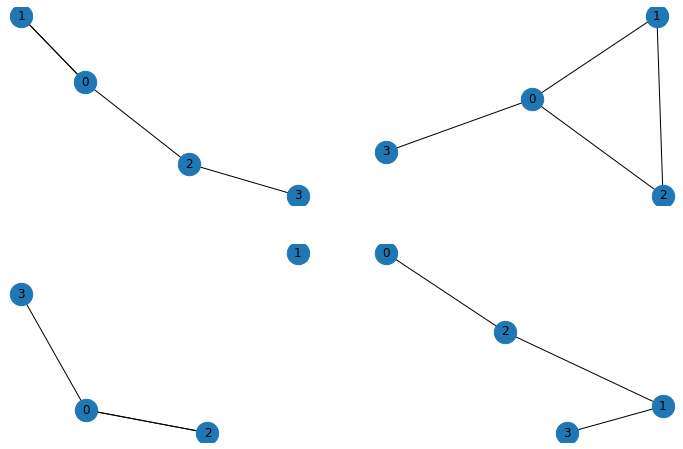

In [2]:
degrees=[3,2,2,1]

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12, 8))

plt.subplot(221)
G=nx.configuration_model(degrees,seed=5)
nx.draw(G,nx.spring_layout(G,iterations=10),node_size=500,with_labels=True)

plt.subplot(222)
G=nx.configuration_model(degrees,seed=10)
nx.draw(G,nx.spring_layout(G,iterations=10),node_size=500,with_labels=True)

plt.subplot(223)
G=nx.configuration_model(degrees,seed=28)
nx.draw(G,nx.spring_layout(G,iterations=10),node_size=500,with_labels=True)

plt.subplot(224)
G=nx.configuration_model(degrees,seed=115)
nx.draw(G,nx.spring_layout(G,iterations=10),node_size=500,with_labels=True)


In [3]:
print(list(G.edges()))
print(list(nx.selfloop_edges(G))) #все петли

[(0, 0), (0, 2), (1, 3), (1, 2)]
[(0, 0)]


### Топология конфигурационной сети:
Ожидаемое число мультиребер:
$$
M=\frac{1}{2} \left(\frac{\langle k^2\rangle-\langle k\rangle}{\langle k\rangle}\right)^2,
$$
Ожидаемое число петель: 
$$
S=\frac{\langle k^2\rangle-\langle k\rangle}{2\langle k\rangle},
$$

Коэффициент кластеризации: 

$$
C=\frac{1}{N} \frac{(\langle k^2\rangle-\langle k\rangle)^2}{\langle k\rangle^3},
$$


#### Задача 1.  Конфигурационная модель сетей со степенным распределением
* напишите функции, вычисляющие по заданному массиву степеней теоретические (ожидаемые) значения числа мультиребер, петель и коэффициент кластеризации;

In [4]:
def exp_n_multiedges(degrees):
    mean_degree = np.array(degrees).mean()
    return 0.5 * (((np.array(degrees)**2).mean() - mean_degree) / 
                  mean_degree)**2

def exp_n_selfloops(degrees):
    mean_degree = np.array(degrees).mean()
    return 0.5 * (((np.array(degrees)**2).mean() - mean_degree) / 
                  mean_degree)

def exp_clustering_coefficient(degrees):
    mean_degree = np.array(degrees).mean()
    return (1. / len(degrees)) * ((((np.array(degrees)**2).mean() - mean_degree)**2) / 
                      mean_degree**3)

* напишите функции, вычисляющие число мультиребер, число петель и средний коэффициент кластеризации для заданного мультиграфа; 

In [5]:
def n_multiedges(G):
    res = 0 
    for i in G.nodes():
        for j in G.neighbors(i):
            if G.number_of_edges(i, j) >= 2:
                res += 1
    return res

def n_selfloops(G):
    return len(list(nx.selfloop_edges(G)))

def G_multi(G):
    G_multi = nx.Graph()

    for i, j, data in G.edges(data=True):
        weight = data['weight'] if 'weight' in data else 1.0

        if G_multi.has_edge(i, j):
            G_multi[i][j]['weight'] += weight
        else:
            G_multi.add_edge(i, j, weight=weight)

    return G_multi

def avg_clustering_coefficient(G):
    return nx.average_clustering(G_multi(G))


* сгенерируйте значения степеней вершин из степенного распределения для различных значений $\gamma \in \left[2.0, 3.0\right]$. Для этих распределений выведите теоретические (ожидаемые) значения числа мультиребер M, петель S и коэффициента кластеризации C, постройте по заданному массиву степеней конфигурационную модель, вычислите наблюдаемые для полученного графа значения M,S,C. Объясните полученные результаты.

Для генерации массива степеней воспользуйтесь функцией (используется [метод обратного преобразования](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BE%D0%B1%D1%80%D0%B0%D1%82%D0%BD%D0%BE%D0%B3%D0%BE_%D0%BF%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F)):

In [6]:
def power_law(gamma, x_min=2, size=1000): #size - размер массива
    x = np.zeros(size, dtype=int)
    for i in range(size):
        r = np.random.random()
        x[i] = int(x_min * np.float_power((r), 1 / (-gamma + 1)))
    return x

In [7]:
print(power_law(2, size=10))

[ 81   7   4   3   2   2   2 532   4  52]


In [8]:
import pandas as pd

gammas = np.linspace(2., 3., 10)
size = 1000

df = (pd.DataFrame(columns=pd.MultiIndex.from_product([['M', 'S', 'C'], 
                                                      ['Expected', 'Real']])).
      reindex(pd.Index(gammas, name='gamma')))


funcs = ((exp_n_multiedges, n_multiedges), (exp_n_selfloops, n_selfloops),
         (exp_clustering_coefficient, avg_clustering_coefficient))

for gamma in gammas:
  degs = power_law(gamma)

  if (degs.sum() % 2) != 0: 
        degs[np.random.randint(0, size)] += 1

  G = nx.configuration_model(degs)
  df.loc[gamma, :] = np.array([(f1(degs), f2(G)) for f1, f2 in funcs]).reshape(-1)

df

M              S               C            
         Expected  Real Expected Real   Expected        Real
gamma                                                       
2.000000  17410.9  1475  93.3031   81    2.56572    0.377798
2.111111  4941.03   676  49.7043   62    1.09703    0.236738
2.222222  53895.2   823  164.157  164    11.8165    0.346025
2.333333  16417.5   746  90.6022   95    3.69597    0.322526
2.444444  14198.8   363  84.2579   93    4.84931    0.165255
2.555556  83.0305    65  6.44323    9  0.0384757   0.0228251
2.666667  27.4891    32  3.70737    2  0.0141624  0.00938034
2.777778  106.789    81  7.30716    6  0.0527354   0.0435872
2.888889  25.2311    22  3.55184    3  0.0138404    0.015756
3.000000  66.5781    51  5.76967    6  0.0358718   0.0205304

#### Задание 2. Распределение степеней ближайших соседей
 * Пусть $\gamma=3$, сгенерируйте массив степеней из степенного распределения, постройте несколько конфигурационных моделей для полученного массива;
 * для каждой вершины определите степени её ближайших соседей, объедините все значения в один массив и постройте распределение степеней. Определите среднее и дисперсию, отличаются ли они от среднего значения степени  вршин в сети и дисперсии? Объясните результаты. 

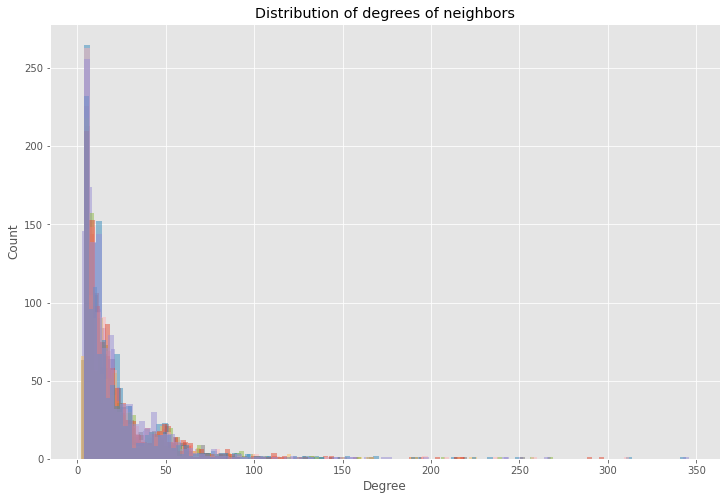

In [9]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 8))

gamma = 3
size = 1000
n_run = 10

degs = power_law(gamma)
if (degs.sum() % 2) != 0: 
  degs[np.random.randint(0, size)] += 1

k_nns = []

for k in range(n_run):
  k_nn = []
  G = nx.configuration_model(degs)

  for i in G.nodes():
    k_nn.append(sum([G.degree(j) for j in G.neighbors(i)]))

  k_nns.append(np.array(k_nn))

  plt.hist(k_nn, bins=100, alpha = 0.5)
  plt.xlabel("Degree")
  plt.ylabel("Count")
    
plt.title('Distribution of degrees of neighbors');

In [10]:
df = pd.DataFrame(columns=['Degree', 'Neighbor degree'], index=['Mean', 'Std'])

df.iloc[0, 0] = degs.mean()
df.iloc[1, 0] = degs.std()
df.iloc[0, 1] = np.array(k_nns).mean()
df.iloc[1, 1] = (np.array(k_nns).mean(axis=0)).std()
df

,Degree,Neighbor degree
Mean,3.33,22.0704
Std,3.3727,21.3557


Видим, что $ \langle k^2 \rangle $ >> $ \langle k \rangle $.

#### Задача 2. Конфигурационная модель сложной сети 
* постройте конфигурационную модель сети заболеваний;
* сравните топологические характеристики сложной сети и ее конфигурационной модели: коэффициент кластеризации, транзитивность, средний кратчайший путь.

In [11]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [12]:
G=nx.read_edgelist('bio-diseasome.txt')

In [13]:
degs = np.array(G.degree, dtype=np.int32)[:, 1]
conf = G_multi(nx.configuration_model(degs))

df = pd.DataFrame(columns=['Network', 'Configuration model'], 
                  index=['Clustering coef.', 'Transitivity', 'Average shortest path'])


for i, g in enumerate((G, conf)):
  df.iloc[0, i] = nx.average_clustering(g)
  df.iloc[1, i] = nx.transitivity(g)
  try:
    df.iloc[2, i] = nx.average_shortest_path_length(g)
  except nx.NetworkXError:
    df.iloc[2, i] = np.nan

df

,Network,Configuration model
Clustering coef.,0.63583,0.0134815
Transitivity,0.430471,0.0203229
Average shortest path,6.50899,NaN
